<a id="1"></a>
<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Classification

## Part 1: Data Cleaning, Preprocessing and EDA (Weather Dataset)

### Contents:
- [Background](#Background)
- [Problem Statement](#Problem-Statement)
- [Data Import](#Data-Import)
- [Data Cleaning](#Data-Cleaning)
- [Preprocessing and EDA](#Preprocessing-and-EDA)
- [Feature Engineering](#Feature-Engineering)

## Background

West Nile virus (WNV) (Flaviviridae: Flavivirus) is an arbovirus circulating among mosquitoes, which serve as the vectors, and wild birds, which serve as the main reservoir hosts. WNV raises public health concerns for its ability to infect humans, which are considered dead-end hosts due to our inability to develop a sufficient viremia to infect mosquitoes. So, environmental surveillance, particularly surveillance based on mosquito sampling, can provide early detection of the virus circulation before the onset of the disease in humans.

WMV is the leading cause of mosquito-borne disease in the continental United States. It is most commonly spread to people by the bite of an infected mosquito. Cases of WNV occur during mosquito season, which starts in the summer and continues through fall. There are no vaccines to prevent or medications to treat WNV in people. Fortunately, most people infected with WNV do not feel sick. About 1 in 5 people who are infected develop a fever and other symptoms. About 1 out of 150 infected people develop a serious, sometimes fatal, illness. ([source](https://www.cdc.gov/westnile/prevention/index.html))

There is no vaccine to prevent WNV infection. The best way to prevent WNV is to protect yourself from mosquito bites. Use insect repellent, wear long-sleeved shirts and pants, treat clothing and gear, and take steps to control mosquitoes indoors and outdoors.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today. Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

So, every year, from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitoes, and the mosquitoes are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitoes, the mosquitoes species, and whether or not West Nile virus is present in the cohort.

## Problem Statement

Given weather, location, testing, and spraying data, we are tasked to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

In [96]:
#!pip install haversine

In [97]:
#!pip install geopy

In [98]:
#!pip install folium

In [99]:
# Import libraries
import numpy as np
import pandas as pd
import re
import pickle

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Pandas settings
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Time Series imports
import datetime as dt
from datetime import datetime
import pytz
import suntime as st
import haversine as hs

# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')
%matplotlib inline
import geopandas as gpd
import geopy.distance
import plotly.express as px
from shapely.geometry import Point, Polygon

#Imports for geospatial visualizations
import folium
from folium.plugins import HeatMapWithTime, MarkerCluster
from branca.element import Figure
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist



#import descartes
#from mpl_toolkits.axes_grid1 import host_subplot
#from mpl_toolkits import axisartist
#from geopy.geocoders import Nominatim

## Data Import

Data from Kaggle:

spray.csv: this is the GIS data for the City of Chicago's spray efforts in 2011 and 2013<br/>
weather.csv: this contains weather conditions of 2007 to 2014, during the months of the tests, from NOAA<br/>
train.csv: this is the training dataset<br/>
test.csv: this is the test dataset<br/>

In [100]:
# Import Data
weather = pd.read_csv('../data/weather.csv')
train = pd.read_csv('../data/train_cleaned.csv')
test = pd.read_csv('../data/test_cleaned.csv')

## Data Cleaning

In [101]:
# Function to get some basic information about each dataframe
def basic_eda(df, df_name):
    print(df_name.upper())
    print()
    print(f"{df_name}.info")
    print(df.info())
    print()
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    print(f"Unique values")
    for col in df.columns:
        print(f"{col}:")
        print(df[col].unique())
        print('\n')
    print("-----\n")

In [102]:
# Function to clean datasets
def clean_data(df, df_name):
    print(df_name.upper())
    print()
    # make columns lowercase
    df.columns = df.columns.str.lower()
    # Converting dtype of 'date' column to 'datetime'
    df['date'] = pd.to_datetime(df['date'])
    # Creating year, month and day variable from date
    df['year'] = df['date'].dt.year 
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    print(df.info())
    print("-----\n")

In [103]:
dfs = [
    (weather, 'weather'),
    (train, 'train'),
    (test, 'test')
    ]

In [104]:
# Get some basic information about each dataframe
[basic_eda(df, name) for df, name in dfs]

WEATHER

weather.info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 14
Percentage dupe rows: 0.16%

Unique values
date:
['2007-05-29' '2007-06-05' '2007-06-26' '2007-06-29' '2007-07-02'
 '2007-07-11' '2007-07-18' '2007-07-19' '2007-07-25' '2007-07-27'
 '2007-08-01' '2007-08-02' '2007-08-03' '2007-08-07' '2007-08-08'
 '2007-08-09' '2007-08-15' '2007-08-16' '2007-08-17' '2007-08-21'
 '2007-08-22' '2007-08-24' '2007-08-28' '2007-09-04' '2007-09-05'
 '2007-09-06' '2007-09-12' '2007-09-18' '2007-09-19' '2007-09-24'
 '2007-09-25' '2007-10-04' '2007-10-09' '2009-05-28' '2009-06-02'
 '2009-06-03' '2009-06-05' '2009-06-12' '2009-06-15' '2009-06-19'
 '2009-06-22' '2009-06-26' '2009-06-29' '2009-07-06' '2009-07-10'
 '2009-07-13' '2009-07-17' '2009-07-24' '2009-07-27' '2009-07-31'
 '2009-08-07' '2009-08-13' '2009-08-25' '2009-08-27' '2009-09-03'
 '2009-09-14' '2009-09-17' '2009-09-25' '2009-10-01' '2011-06-10'
 '2011-06-17' '2011-06-24' '2011-06-30' '2011-07-11' '2011-07-15'
 '2011-07-25' '2011-0

[None, None, None]

In [105]:
# Clean each dataframe
[clean_data(df, name) for df, name in dfs]

WEATHER

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   object        
 5   depart       2944 non-null   object        
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2944 non-null   object        
 8   heat         2944 non-null   object        
 9   cool         2944 non-null   object        
 10  sunrise      2944 non-null   object        
 11  sunset       2944 non-null   object        
 12  codesum      2944 non-null   object        
 13  depth        2944 non-null   object        
 14  water1       2944 non-null   object        
 15  snowfall     2944 non-null   object        
 1

[None, None, None]

[Back to top](#1)

## Preprocessing and EDA

### Weather dataset

We have weather data for 8 years from 2007 to 2014.</br>
Only 6 out of 12 months of data available (end spring, summer, early autumn).</br>
It was also observed that the weather data came as two sets from below two stations (1,2) for a given date.

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level</br>
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [106]:
# Functions for plotting

def subplot_hist(dataframe,list_of_columns, suptitle, list_of_titles,datafigsize):
    fig, ax = plt.subplots((len(list_of_columns)//2), 2,figsize= datafigsize) 
    fig.suptitle(suptitle,fontsize=30)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    plt.tight_layout(h_pad = 2,pad=5);
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column],color="lightblue") 
        ax[i].set_title(list_of_titles[i],fontdict={'fontsize': 15})
        ax[i].xaxis.set_visible(True)
        ax[i].axvline(dataframe[column].mean(), color='r', linestyle='dashed', linewidth=1,label='mean')
        ax[i].axvline(dataframe[column].median(), color='b', linestyle='dashed', linewidth=1,label="median")
        ax[i].legend(loc='upper right');

def subplot_line(col_name, df):
    df.groupby(by = ['year','month'])[col_name].mean().plot(title = f'Mean {col_name} values for each month in each year ',figsize = (8,3))
    pd.pivot_table(df.reset_index(),index='month', columns='year', values=col_name).plot(subplots=False,
    sharey = True, sharex = True, figsize = (8,5), ylabel = col_name, xlabel = 'Month');
    
def subplot_dist(col_name, df, dist_title, dist_xlabel, line_title, line_xlabel, line_ylabel):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = ax.ravel()
    sns.distplot(df[col_name], ax=ax[0])
    df.groupby(['month','year'])[col_name].mean().unstack(fill_value=0).plot(
        ax=ax[1], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

    ax[0].set_title(dist_title, fontsize=14, y=1.01)
    ax[0].set_xlabel(dist_xlabel, fontsize=12)
    ax[0].tick_params(labelsize=12)

    ax[1].set_title(line_title, fontsize=14, y=1.01)
    ax[1].set_xlabel(line_xlabel, fontsize=12)
    ax[1].set_ylabel(line_ylabel, fontsize=12)
    ax[1].tick_params(labelsize=12)
    ax[1].legend(fontsize=12)

    plt.subplots_adjust(wspace=0.2)

In [107]:
# Function for string mapper 
def mt_mapper(df,columns):
    for i in columns:
        df[i] = df[i].apply(lambda x: np.nan if x =='M' else x)# replace values with 'M' as np.nan
        df[i] = df[i].apply(lambda x: 0 if x =='  T' else x) # replace values with 'T' as 0     
        df[i] = df[i].astype('float') # Convert dataype of index as float

In [108]:
#create a copy of weather dataset for eda
weather_copy = weather.copy(deep = True)

<b>Values with "M", "T" and "-"</b>

As observed, we have quite a few columns having "M" and "  T" values causing them to be classfied as 'object' columns when the remaining values are numerical in nature. Sunset and Sunrise columns also have "-" values, which seems to only come from data logged by Station 2.</br>

According to the column descriptions in "noaa_weather_qclcd_documentation",</br> 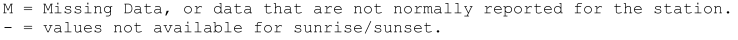

To facilitate processing, we will map all columns with "M" values as np.nan, as M denotes data is not recorded at a particular station.

We will map all columns with "  T" values as 0 as T denotes a Trace.

It is also stated in the noaa weather document that Sunset and Sunrise are calculated instead of observed. So for the "-' values, we are able to calculate the Sunset and Sunrise times with the help of external libraries and use the calculated values for imputation.

In [109]:
# Map columns with "M" values as np.nan, and columns with " T" values as 0
cols_to_fill = ['tavg', 'depart', 'wetbulb', 'heat', 'cool', 'depth','water1', 'snowfall','preciptotal','stnpressure','sealevel','avgspeed']
mt_mapper(weather_copy, cols_to_fill)

<b>Null values</b>

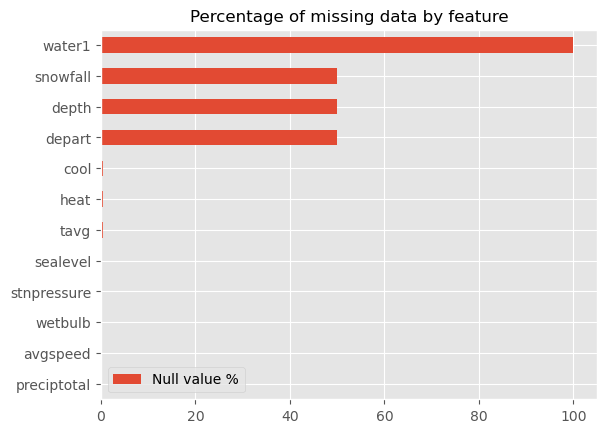

In [110]:
# Identify columns with null values
def plot_null(df):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=True)
        null_data = pd.DataFrame({'Null value %' :na_df})
        null_data.plot(kind = "barh")
        plt.title('Percentage of missing data by feature', fontsize=12)
        plt.show()
    else:
        print('No NAs found')

plot_null(weather_copy)

The below columns will be dropped, as they have 50% or more missing values and are not likely to have valuable information.

- Water1: 100% missing values, no valuable information which can be derived
- Depature: While having some degree of variability, too many missing values are present (50% missing values)
- SnowFall: 50% missing values, too little variation between values
- Depth: 50% missing values, no variation between values (0, 'nan')

In [111]:
# Drop columns
weather.drop(columns=['water1', 'snowfall', 'depth','depart'], inplace=True)

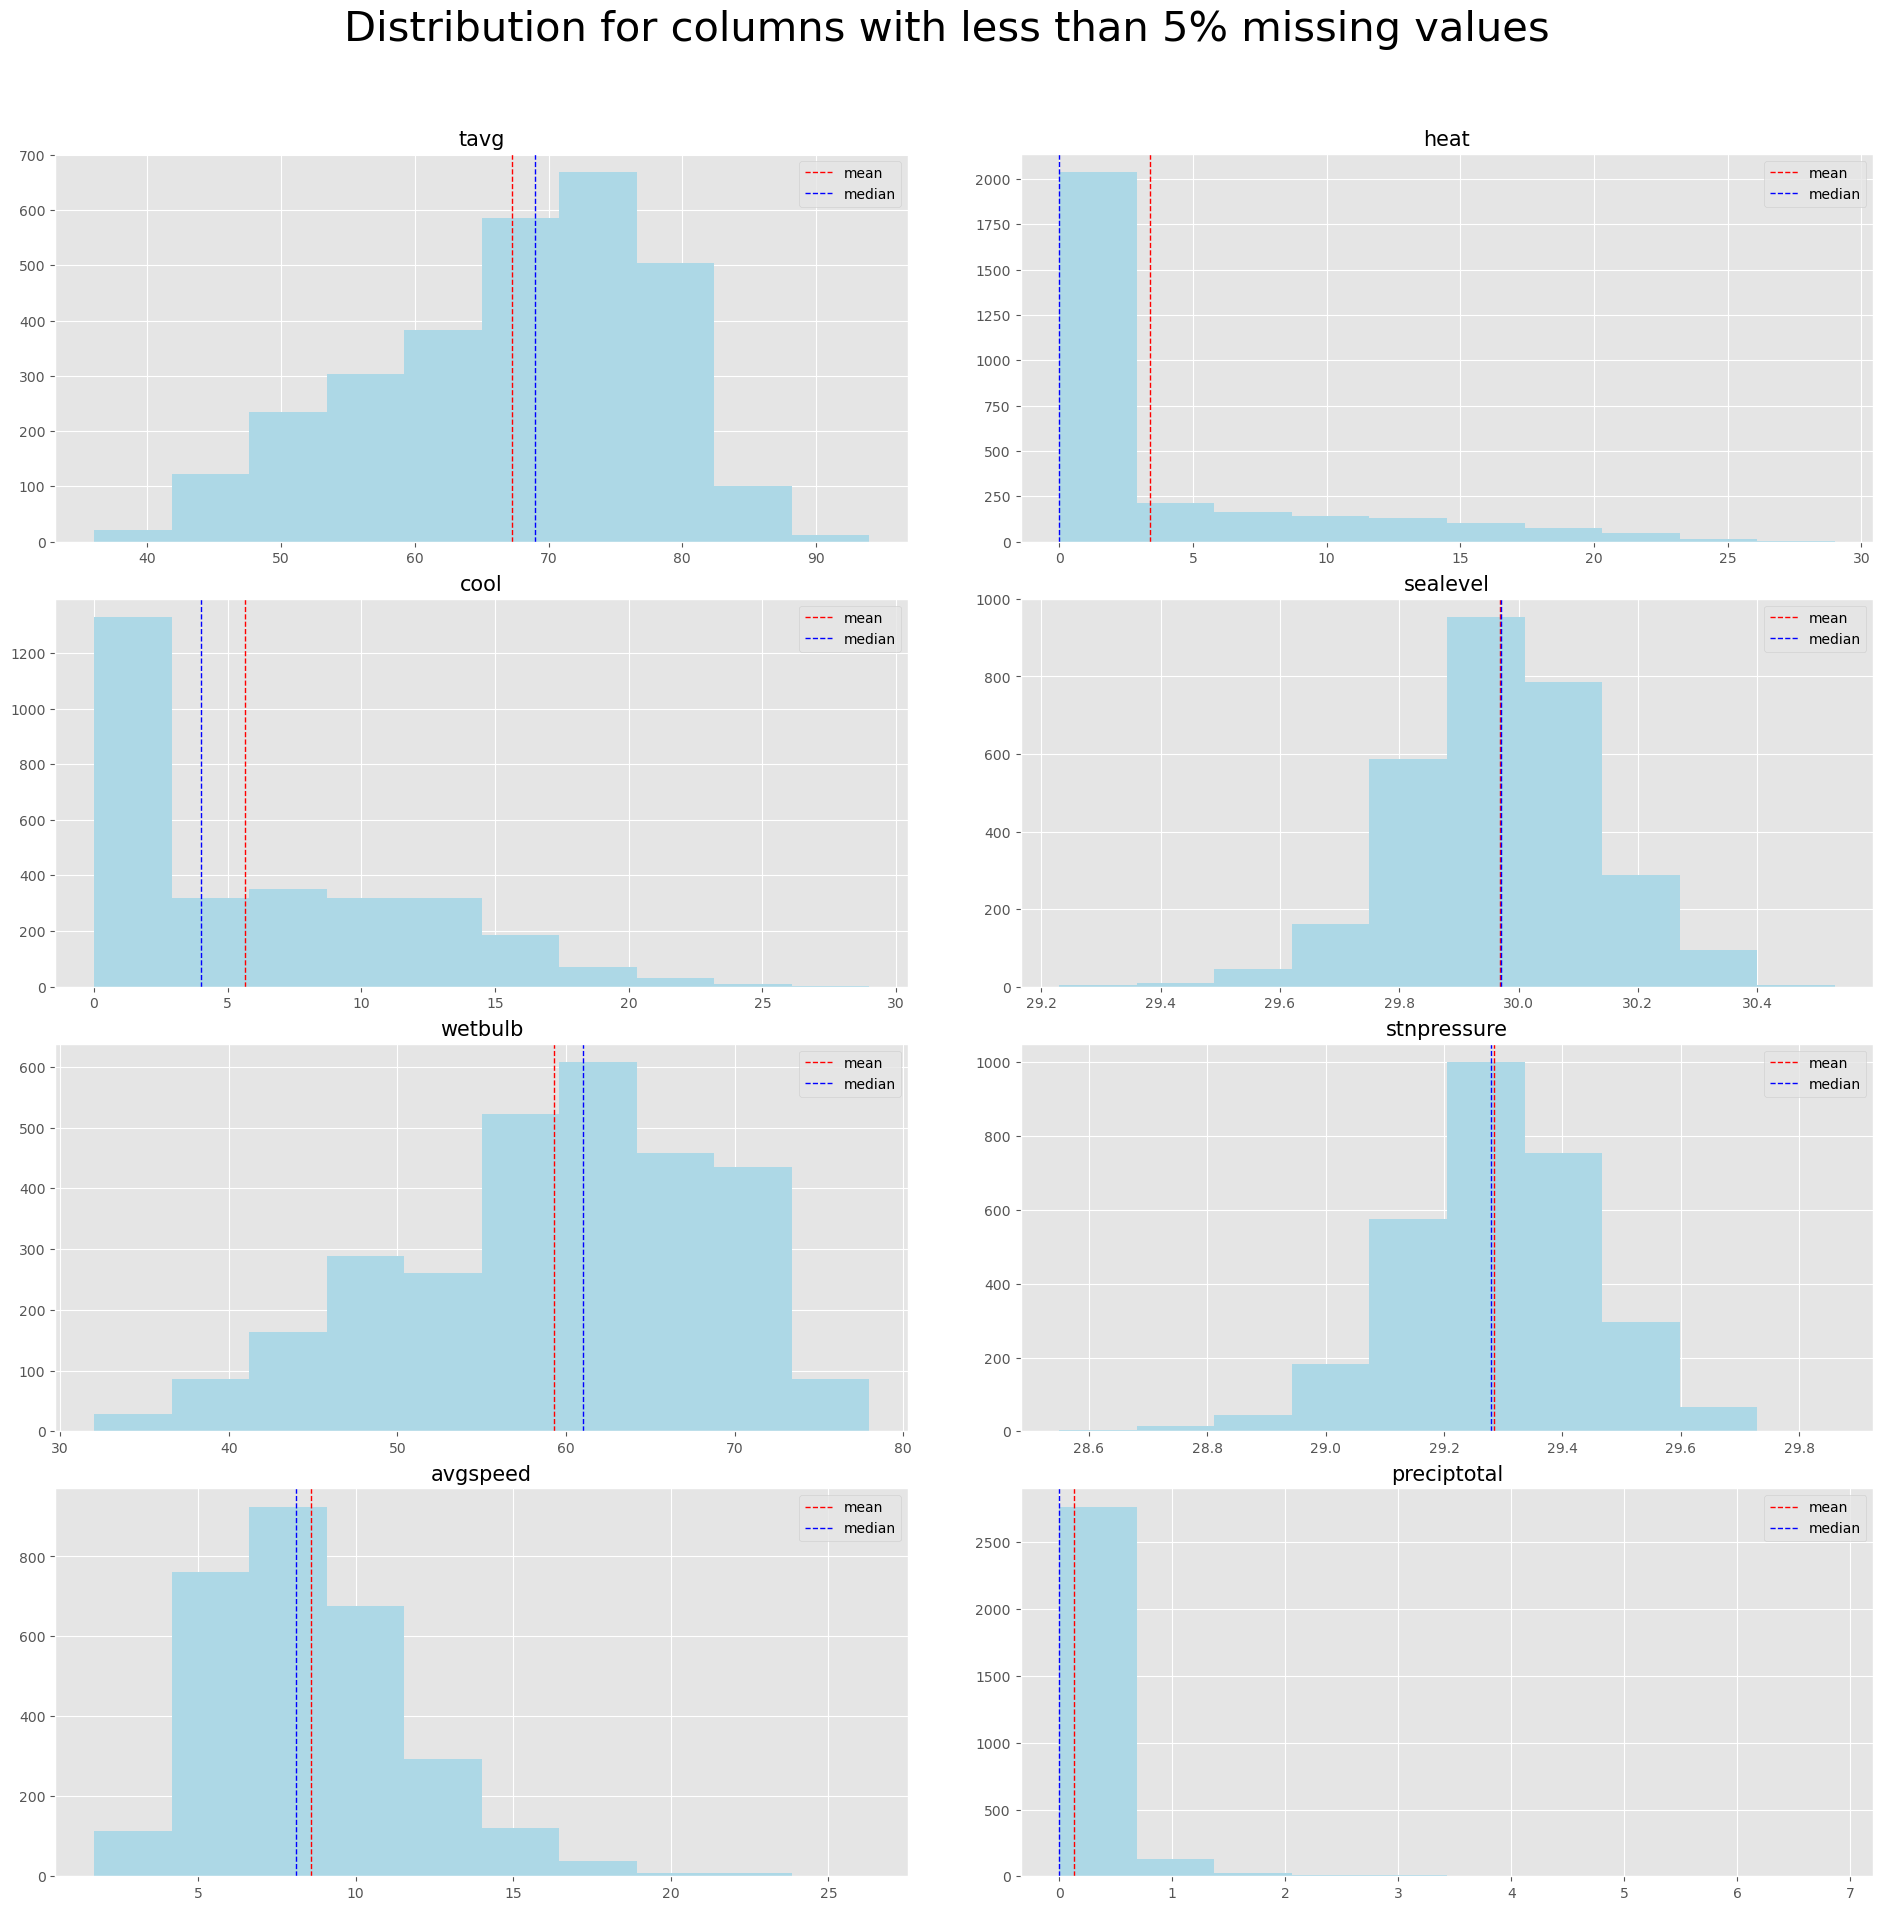

In [112]:
# Visualizing columns with less than 5% missing values
col_lessthan5 = ['tavg', 'heat', 'cool','sealevel','wetbulb','stnpressure','avgspeed','preciptotal']  
subplot_hist(weather_copy,col_lessthan5,"Distribution for columns with less than 5% missing values ", col_lessthan5,(20,20))

<b>Impute Missing data</b>

We can impute the missing data (except 'Tavg') in two ways:

1. If data is missing from one station, we impute the data from the other station.
2. If data is missing from both stations on the same day, we impute forwardfill the data from its own station. 

Columns affected: 
- heat
- cool
- sealevel
- wetbulb
- stnpressure
- avgspeed

The actual value of 'Tavg' can be calculated by a such: Tmax + Tmin / 2 which would provide more accurate values than using median.

For 'preciptotal' column, Trace denotes that there is an amount of precipitation, which is greater than zero but is too small to be measured. Therefore, As the lowest value in PrecipTotal is 0 and the second lowest is 0.01, we will choose the median,0.05 and replace the T values.

In [113]:
# Imputing 'Tavg' using above mentioned formula,
weather['tavg'] = (weather['tmax'] + weather['tmin']) / 2

weather.isnull().sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
year           0
month          0
day            0
dtype: int64

In [114]:
# PrecipTotal
# Replace T with 0.005
weather.loc[weather['preciptotal'] == '  T', 'preciptotal'] = 0.005
weather.loc[weather['preciptotal'] == 'M', 'preciptotal'] = 0.005

In [115]:
#replace values from the other station 
#[+1] is the next value in the new row (since station 2 is recorded after station 1)
#[-1] is the previous value (since station 1 is before station 2)

def replace_fromstation(row, feature):
    '''replace missing value with a value on the same date, but from the other station'''
    for i in range(len(row)):
        if row[feature][i] == 'M':
            if row['station'][i] == 1:
                row[feature][i] = weather[(weather['date']== row['date'][i]) & (weather['station']==2)][feature][i+1]
            else:
                row[feature][i] = weather[(weather['date']== row['date'][i]) & (weather['station']==1)][feature][i-1]
    return row

In [116]:
#replace missing values
replace_fromstation(weather, 'heat')
replace_fromstation(weather, 'cool')
replace_fromstation(weather, 'sealevel')
replace_fromstation(weather, 'wetbulb')
replace_fromstation(weather, 'stnpressure')
replace_fromstation(weather, 'avgspeed')

station       date  tmax  tmin  tavg  dewpoint wetbulb heat cool  \
0           1 2007-05-01    83    50  66.5        51      56    0    2   
1           2 2007-05-01    84    52  68.0        51      57    0    3   
2           1 2007-05-02    59    42  50.5        42      47   14    0   
3           2 2007-05-02    60    43  51.5        42      47   13    0   
4           1 2007-05-03    66    46  56.0        40      48    9    0   
5           2 2007-05-03    67    48  57.5        40      50    7    0   
6           1 2007-05-04    66    49  57.5        41      50    7    0   
7           2 2007-05-04    78    51  64.5        42      50    7    0   
8           1 2007-05-05    66    53  59.5        38      49    5    0   
9           2 2007-05-05    66    54  60.0        39      50    5    0   
10          1 2007-05-06    68    49  58.5        30      46    6    0   
11          2 2007-05-06    68    52  60.0        30      46    5    0   
12          1 2007-05-07    83    47  65.0        41      54    0    0   
13          2 2007-05-07    84    50  67.0        39      53    0    2   
14          1 2007-05-08    82    54  68.0        58      62    0    3   
15          2 2007-05-08    80    60  70.0        57      63    0    5   
16          1 2007-05-09    77    61  69.0        59      63    0    4   
17          2 2007-05-09    76    63  69.5        60      63    0    5   
18          1 2007-05-10    84    56  70.0        52      60    0    5   
19          2 2007-05-10    83    59  71.0        52      61    0    6   
20          1 2007-05-11    70    51  60.5        42      51    4    0   
21          2 2007-05-11    73    49  61.0        44      51    4    0   
22          1 2007-05-12    64    46  55.0        36      46   10    0   
23          2 2007-05-12    65    47  56.0        37      46    9    0   
24          1 2007-05-13    69    43  56.0        33      46    9    0   
25          2 2007-05-13    69    44  56.5        32      46    8    0   
26          1 2007-05-14    90    56  73.0        47      59    0    8   
27          2 2007-05-14    90    54  72.0        45      58    0    7   
28          1 2007-05-15    80    57  68.5        56      61    0    4   
29          2 2007-05-15    82    56  69.0        56      61    0    4   
30          1 2007-05-16    66    44  55.0        43      48   10    0   
31          2 2007-05-16    64    45  54.5        42      47   10    0   
32          1 2007-05-17    62    43  52.5        32      43   12    0   
33          2 2007-05-17    61    44  52.5        32      43   12    0   
34          1 2007-05-18    71    42  56.5        30      46    8    0   
35          2 2007-05-18    70    43  56.5        31      47    8    0   
36          1 2007-05-19    80    56  68.0        39      53    0    3   
37          2 2007-05-19    80    56  68.0        37      53    0    3   
38          1 2007-05-20    69    43  56.0        40      44    9    0   
39          2 2007-05-20    69    44  56.5        41      45    8    0   
40          1 2007-05-21    80    44  62.0        50      56    3    0   
41          2 2007-05-21    79    46  62.5        50      57    2    0   
42          1 2007-05-22    87    55  71.0        46      58    0    6   
43          2 2007-05-22    87    60  73.5        44      58    0    9   
44          1 2007-05-23    89    60  74.5        49      61    0   10   
45          2 2007-05-23    89    66  77.5        48      61    0   13   
46          1 2007-05-24    88    63  75.5        54      63    0   11   
47          2 2007-05-24    88    66  77.0        53      63    0   12   
48          1 2007-05-25    70    56  63.0        44      53    2    0   
49          2 2007-05-25    66    57  61.5        46      53    3    0   
50          1 2007-05-26    65    49  57.0        55      56    8    0   
51          2 2007-05-26    70    50  60.0        55      57    5    0   
52          1 2007-05-27    75    57  66.0        47      56    0    1   
53        

In [117]:
#check for 'M' in weather dataframe
for col in weather.select_dtypes(include=['object']).columns:
    print(col, weather[col].str.count('M').sum())

wetbulb 0
heat 0
cool 0
sunrise 0
sunset 0
codesum 3
preciptotal 0.0
stnpressure 2
sealevel 0
avgspeed 0


In [118]:
#check M rows in stnpressure column
weather[weather['stnpressure']== 'M']

station       date  tmax  tmin  tavg  dewpoint wetbulb heat cool  \
2410        1 2013-08-10    81    64  72.5        57      63    0    8   
2411        2 2013-08-10    81    68  74.5        55      63    0   10   

     sunrise sunset codesum preciptotal stnpressure sealevel  resultspeed  \
2410    0454   1900                0.00           M    30.08          5.3   
2411       -      -                0.00           M    30.07          6.0   

      resultdir avgspeed  year  month  day  
2410          5      6.5  2013      8   10  
2411          6      7.4  2013      8   10

Turns out station pressure is missing in both stations for this date. So this will be changed manually. Data on this date will be replaced from the day before. 

In [119]:
# Create list of index where stnpressure is missing from both stations on the same day.
idx = weather.index[weather['stnpressure'].str.contains('M')].tolist()

# Frontfill 2 indices before because of the way the dataframe is sorted [station1, station2]
weather['stnpressure'][idx[0]] = weather['stnpressure'][idx[0]-2]
weather['stnpressure'][idx[1]] = weather['stnpressure'][idx[1]-2]

In [120]:
# Assign stations coordinates
stn1 = (41.995, -87.933)
stn2 = (41.786, -87.752)

In [121]:
# Initializing Sun object with lat. long. values of station 2
s = st.Sun(stn2[0],stn2[1])
# Storing UTC as our timezone
utc = pytz.timezone('US/Central')

# Initializing empty lists to store sunrise/sunset times for given dates
sunrise_list = []
sunset_list = []
for value in weather['date']:
    time_sr = s.get_local_sunrise_time(value, local_time_zone=utc)
    time_sr = time_sr - time_sr.dst()
    time_ss = s.get_local_sunset_time(value, local_time_zone=utc)
    time_ss = time_ss - time_ss.dst()
    sunrise_list.append(time_sr.strftime('%H%M'))
    sunset_list.append(time_ss.strftime('%H%M'))

# Impute values
index = weather.loc[weather['station']==2].index
for i in index:
    weather.loc[i, 'sunrise'] = sunrise_list[i]
    weather.loc[i, 'sunset'] = sunset_list[i]

In [122]:
weather['sunrise'].unique()

array(['0448', '0447', '0446', '0445', '0444', '0443', '0442', '0441',
       '0440', '0439', '0438', '0437', '0436', '0435', '0434', '0433',
       '0432', '0431', '0430', '0429', '0428', '0427', '0426', '0425',
       '0424', '0423', '0422', '0421', '0420', '0419', '0418', '0417',
       '0416', '0449', '0450', '0451', '0452', '0453', '0454', '0455',
       '0456', '0457', '0458', '0459', '0500', '0501', '0502', '0503',
       '0504', '0505', '0506', '0508', '0507', '0509', '0510', '0511',
       '0512', '0513', '0514', '0515', '0516', '0517', '0518', '0519',
       '0520', '0521', '0522', '0523', '0524', '0525', '0526', '0527',
       '0528', '0529', '0530', '0531', '0532', '0533', '0535', '0534',
       '0536', '0537', '0538', '0539', '0540', '0541', '0542', '0543',
       '0544', '0545', '0546', '0547', '0548', '0549', '0550', '0552',
       '0551', '0553', '0554', '0555', '0556', '0557', '0558', '0559',
       '0600', '0602', '0601', '0603', '0604', '0605', '0606', '0607',
      

In [123]:
weather['sunset'].unique()

array(['1849', '1850', '1851', '1852', '1853', '1855', '1854', '1856',
       '1857', '1858', '1859', '1860', '1900', '1901', '1902', '1903',
       '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911',
       '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919',
       '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927',
       '1928', '1929', '1930', '1931', '1848', '1847', '1845', '1846',
       '1844', '1842', '1843', '1841', '1839', '1840', '1838', '1836',
       '1837', '1834', '1835', '1833', '1831', '1832', '1830', '1828',
       '1829', '1826', '1827', '1825', '1823', '1824', '1821', '1822',
       '1820', '1818', '1819', '1816', '1817', '1814', '1815', '1813',
       '1811', '1812', '1809', '1810', '1808', '1806', '1807', '1804',
       '1805', '1802', '1803', '1801', '1760', '1759', '1758', '1757',
       '1756', '1755', '1754', '1753', '1752', '1751', '1750', '1749',
       '1748', '1747', '1746', '1745', '1744', '1743', '1742', '1741',
      

Mosquitoes are more likely to bite when the weather is warm and sunny. This is because they like to breed in warm, humid areas. Mosquitoes are cold-blooded insects. They prefer to live in areas that are around 70-80 degrees Fahrenheit. The large number of weather codes are too specific and not interpretable. We can map these weather codes to either wet (1) or dry (0).

In [124]:
#Creating of features for each condition in codesum
code_sums = []
wet_codes = ['RA', 'TS', 'DZ', 'BR', 'UP', 'SH']

for code in weather['codesum']:
    code.replace('+', ' ')
    code_row = code.split()
    check_wet = 0
    for val in code_row:
        val_2 = None
        if len(val) > 2:
            val_1 = val[:2]
            val_2 = val[2:]
        else:
            val_1 = val
        
        if val_1 in wet_codes or val_2 in wet_codes:
            check_wet = 1

    code_sums.append(check_wet)

In [125]:
#rename codesum column
weather['codesum'] = code_sums
weather.rename(columns = {'codesum': 'wetdry'}, inplace = True)

In [126]:
weather.head()

station       date  tmax  tmin  tavg  dewpoint wetbulb heat cool sunrise  \
0        1 2007-05-01    83    50  66.5        51      56    0    2    0448   
1        2 2007-05-01    84    52  68.0        51      57    0    3    0448   
2        1 2007-05-02    59    42  50.5        42      47   14    0    0447   
3        2 2007-05-02    60    43  51.5        42      47   13    0    0447   
4        1 2007-05-03    66    46  56.0        40      48    9    0    0446   

  sunset  wetdry preciptotal stnpressure sealevel  resultspeed  resultdir  \
0   1849       0        0.00       29.10    29.82          1.7         27   
1   1849       0        0.00       29.18    29.82          2.7         25   
2   1850       1        0.00       29.38    30.09         13.0          4   
3   1850       1        0.00       29.44    30.08         13.3          2   
4   1851       0        0.00       29.39    30.12         11.7          7   

  avgspeed  year  month  day  
0      9.2  2007      5    1  
1      9.6  2007      5    1  
2     13.4  2007      5    2  
3     13.4  2007      5    2  
4     11.9  2007      5    3

In [127]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   float64       
 5   dewpoint     2944 non-null   int64         
 6   wetbulb      2944 non-null   object        
 7   heat         2944 non-null   object        
 8   cool         2944 non-null   object        
 9   sunrise      2944 non-null   object        
 10  sunset       2944 non-null   object        
 11  wetdry       2944 non-null   int64         
 12  preciptotal  2944 non-null   object        
 13  stnpressure  2944 non-null   object        
 14  sealevel     2944 non-null   object        
 15  resultspeed  2944 non-null   float64       
 16  result

In [128]:
cols =['wetbulb', 'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel', 'avgspeed']
weather[cols] = weather[cols].apply(pd.to_numeric, downcast = 'float')

### Visualisation of weather features

`Average Temperature`

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/829887096.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=weather,x='month',y='tavg',hue='year', ci=None)


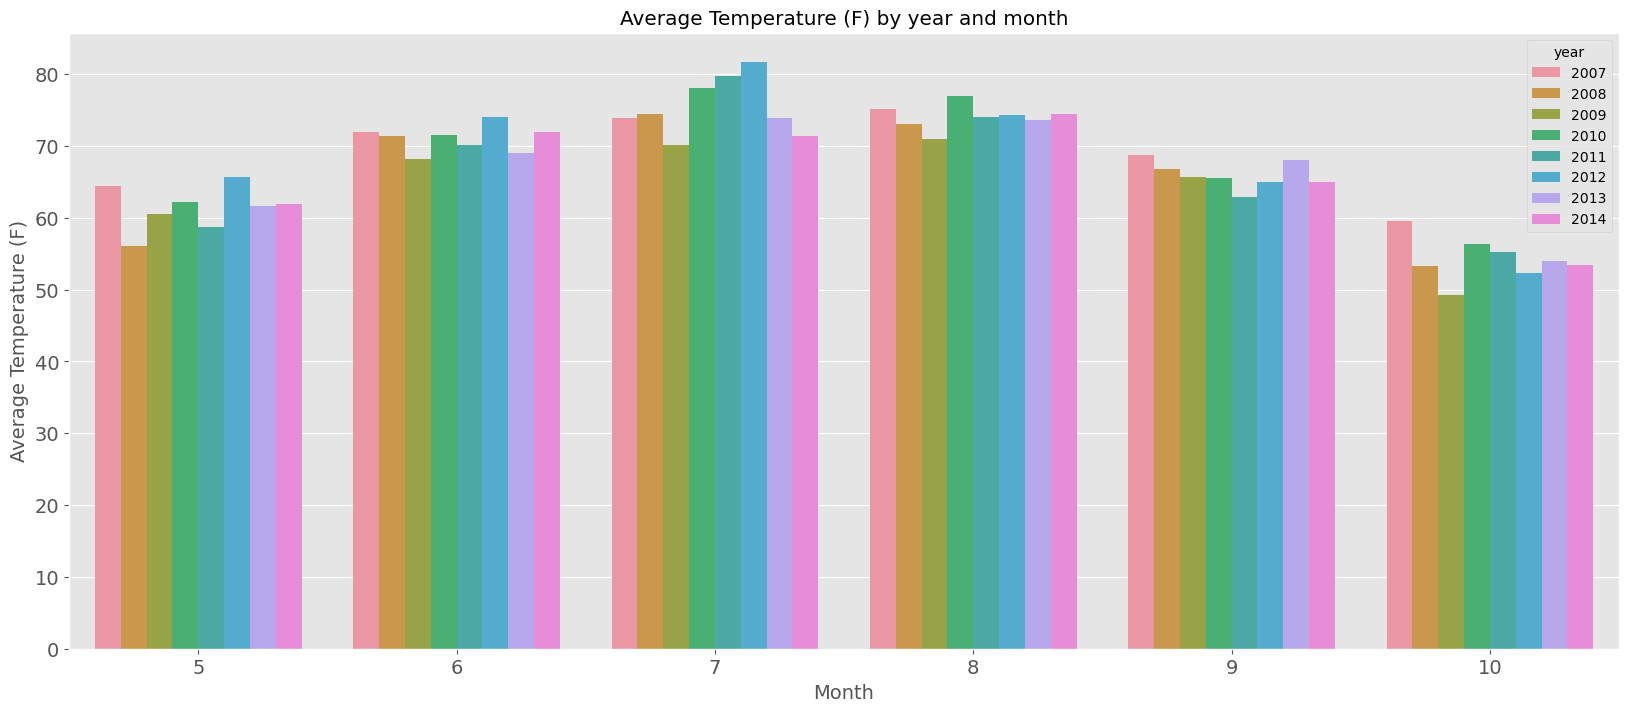

In [129]:
plt.figure(figsize=(20,8))

sns.barplot(data=weather,x='month',y='tavg',hue='year', ci=None)
plt.title('Average Temperature (F) by year and month')
plt.ylabel('Average Temperature (F)', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.tick_params(labelsize=14)

As shown above, 2012 has the highest average temperature for 3 out of 6 months i.e. highest temperature for May, Jun and Jul. 2009 has the lowest average temperature for 4 out of 6 months i.e. highest temperature for Jun, Jul, Aug and Oct. Average temperature generally peaks in Jul and Aug.

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/4122376323.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(weather[weather['station']==1].tavg, ax=ax[0])
/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/4122376323.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.d

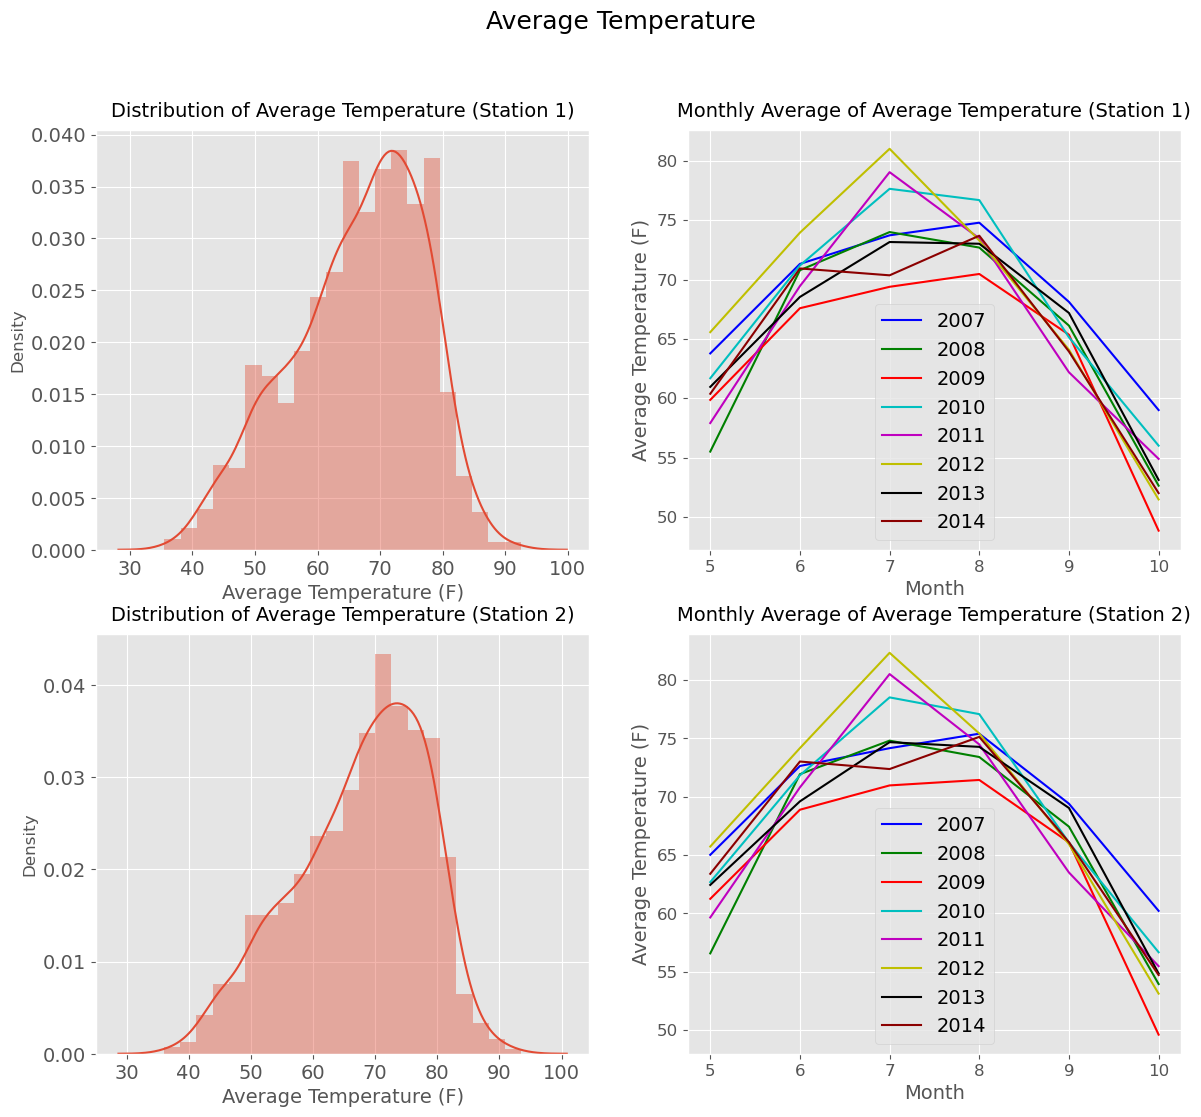

In [130]:
# Plot distribution of average temperature for both stations, and breakdown of each year
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
ax = ax.ravel()
plt.suptitle('Average Temperature', fontsize=18)

sns.distplot(weather[weather['station']==1].tavg, ax=ax[0])
weather[weather['station']==1].groupby(['month','year']).tavg.mean().unstack(fill_value=0).plot(
    ax=ax[1], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

sns.distplot(weather[weather['station']==2].tavg, ax=ax[2])
weather[weather['station']==2].groupby(['month','year']).tavg.mean().unstack(fill_value=0).plot(
    ax=ax[3], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

ax[0].set_title('Distribution of Average Temperature (Station 1)', fontsize=14, y=1.01)
ax[0].set_xlabel('Average Temperature (F)', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Monthly Average of Average Temperature (Station 1)', fontsize=14, y=1.01)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Average Temperature (F)', fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].legend(fontsize=14)

ax[2].set_title('Distribution of Average Temperature (Station 2)', fontsize=14, y=1.01)
ax[2].set_xlabel('Average Temperature (F)', fontsize=14)
ax[2].tick_params(labelsize=14)

ax[3].set_title('Monthly Average of Average Temperature (Station 2)', fontsize=14, y=1.01)
ax[3].set_xlabel('Month', fontsize=14)
ax[3].set_ylabel('Average Temperature (F)', fontsize=14)
ax[3].tick_params(labelsize=12)
ax[3].legend(fontsize=14)

plt.subplots_adjust(wspace=0.2)

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


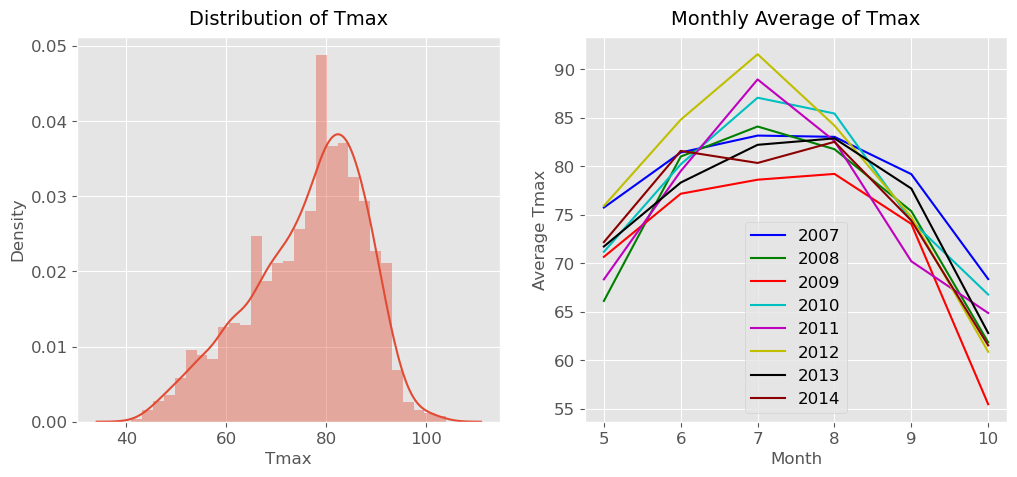

In [131]:
# Plot distribution of average Tmax and breakdown of each year
subplot_dist('tmax',weather,'Distribution of Tmax','Tmax',\
            'Monthly Average of Tmax','Month','Average Tmax')

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


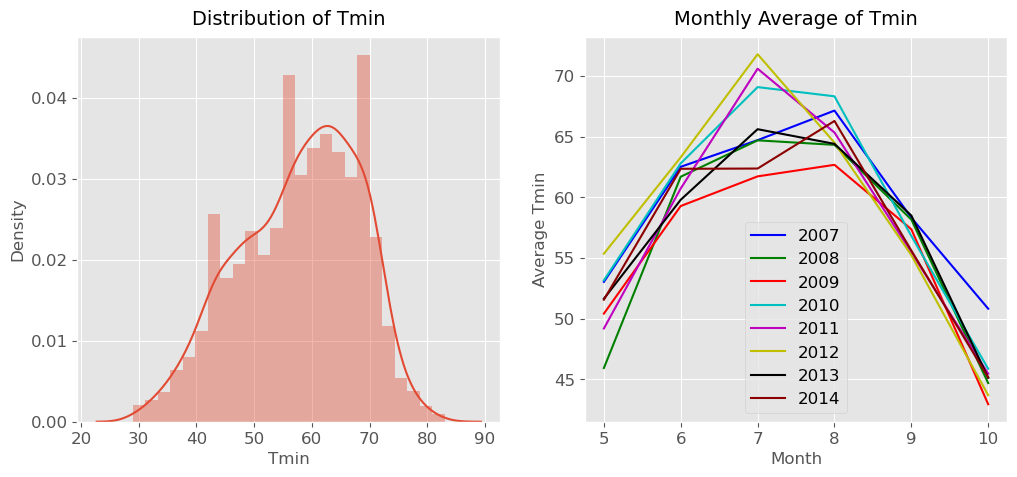

In [132]:
# Plot distribution of average Tmin and breakdown of each year
subplot_dist('tmin',weather,'Distribution of Tmin','Tmin',\
            'Monthly Average of Tmin','Month','Average Tmin')

- Distribution of Tavg, Tmax and Tmin does not follow a normal distribution.
- Average temperature peaks in Jul or Aug each year.
- Tavg, Tmax and Tmin values are similar to each other, suggesting that they are correlated with one another.

`Dewpoint`

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


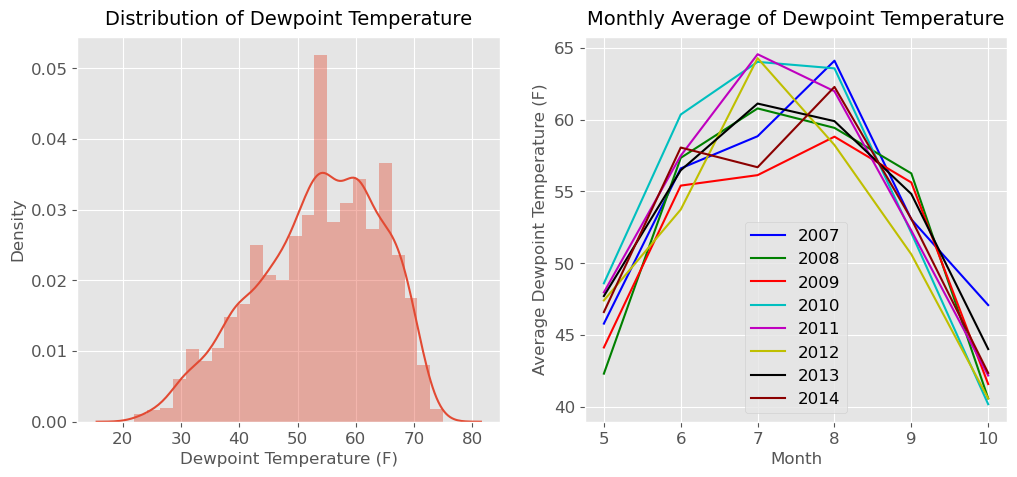

In [133]:
# Plot distribution of average dewpoint temperature and breakdown of each year
subplot_dist('dewpoint',weather,'Distribution of Dewpoint Temperature','Dewpoint Temperature (F)',\
            'Monthly Average of Dewpoint Temperature','Month','Average Dewpoint Temperature (F)')

- Distribution of dewpoint temperature does not follow a normal distribution. 
- Dewpoint temperature peaks in Jul or Aug each year.

`Wetbulb`

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


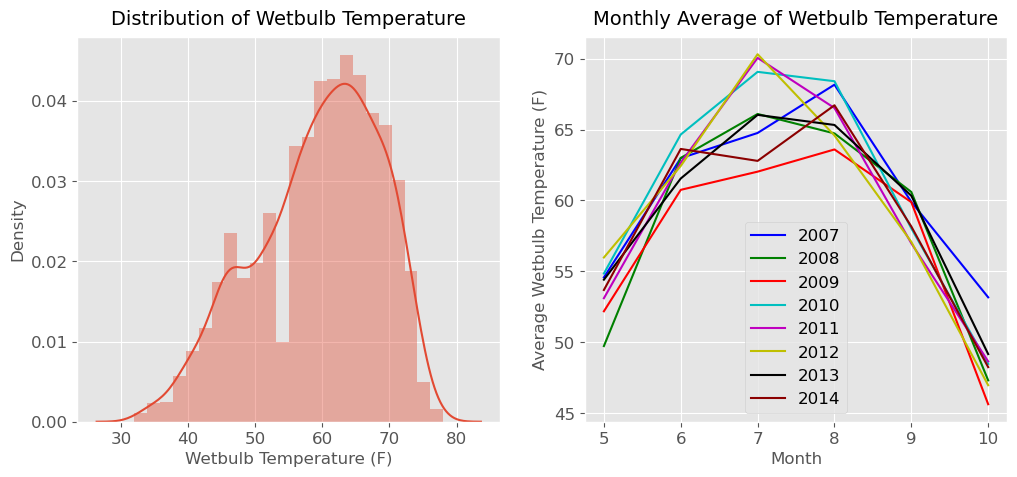

In [134]:
# Plot distribution of average wetbulb temperature and and breakdown of each year
subplot_dist('wetbulb',weather,'Distribution of Wetbulb Temperature','Wetbulb Temperature (F)',\
            'Monthly Average of Wetbulb Temperature','Month','Average Wetbulb Temperature (F)')

- Distribution of wetbulb temperature does not follow a normal distribution.
- Wetbulb temperature peaks in Jul or Aug each year.
- Wetbulb values is similar to that of Dewpoint, suggesting that the two may be collinear with one another.

`Heat`

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


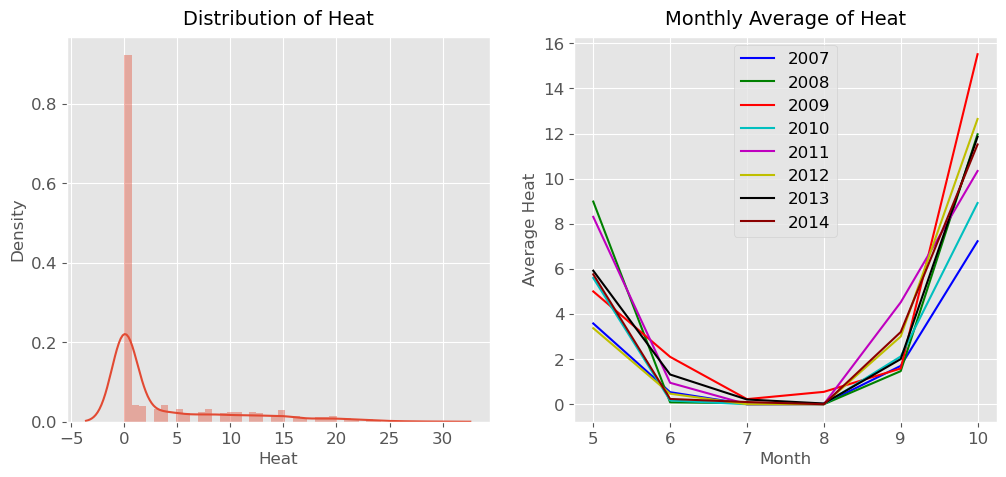

In [135]:
# Plot distribution of average Heat and breakdown of each year
subplot_dist('heat',weather,'Distribution of Heat','Heat',\
            'Monthly Average of Heat','Month','Average Heat')

`Cool`

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


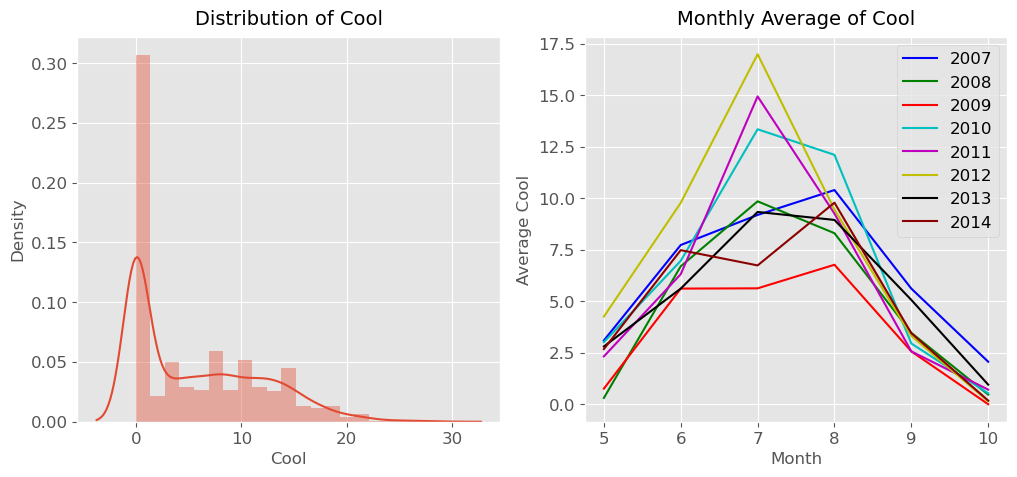

In [136]:
# Plot distribution of average Cool and breakdown of each year
subplot_dist('cool',weather,'Distribution of Cool','Cool',\
            'Monthly Average of Cool','Month','Average Cool')

Heat and Cool seem to track deviance from a specific temperature. While both of them exhibit traits of seasonality, they also seem to have an inverse relationship with one another (i.e Highest mean value for Heat will correspond to lowest mean value for Cool). As we have no idea what is the specified temperature by which the deviance is tracked, we can instead look at just the Tavg variable to indicate both hot or cold temperatures.

`Precipitation`

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


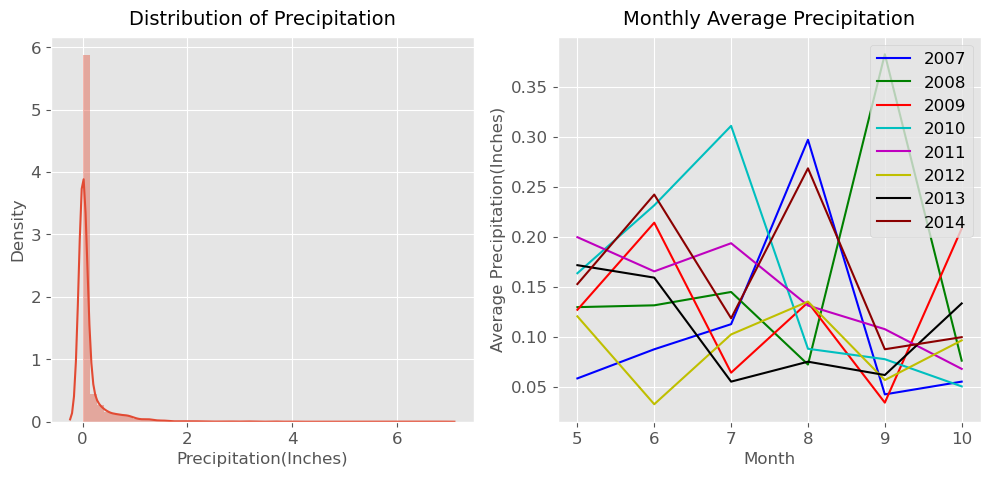

In [137]:
# Plot distribution of average Precipitation and breakdown of each year
subplot_dist('preciptotal',weather,'Distribution of Precipitation','Precipitation(Inches)',\
            'Monthly Average Precipitation','Month','Average Precipitation(Inches)')

- Distribution of precipitation does not follow a normal distribution.
- Monthly average precipitation does not show any trend throughout the years.

`StnPressure`

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


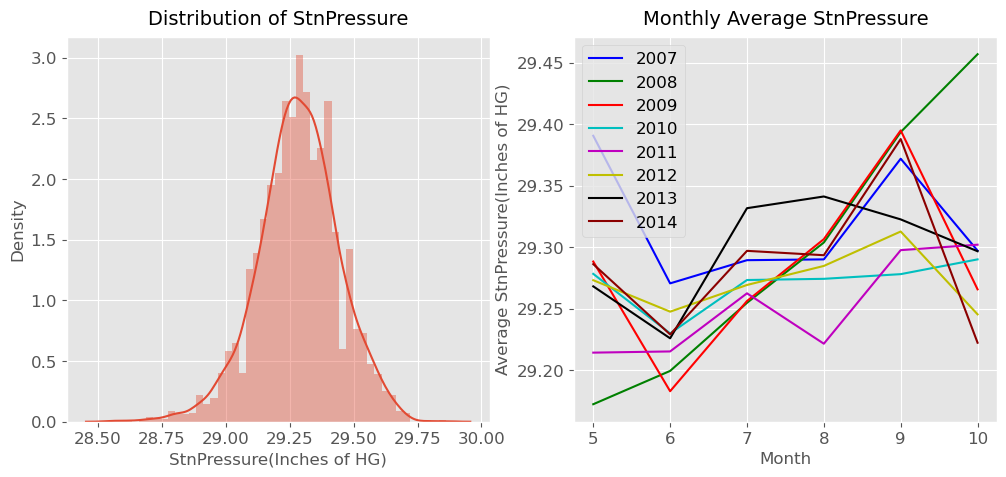

In [138]:
# Plot distribution of average StnPressure and breakdown of each year
subplot_dist('stnpressure',weather,'Distribution of StnPressure','StnPressure(Inches of HG)',\
            'Monthly Average StnPressure','Month','Average StnPressure(Inches of HG)')

- Distribution of StnPressure follows a normal distribution.
- Monthly average StnPressure does not show any trend throughout the years.

`SeaLevel`

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


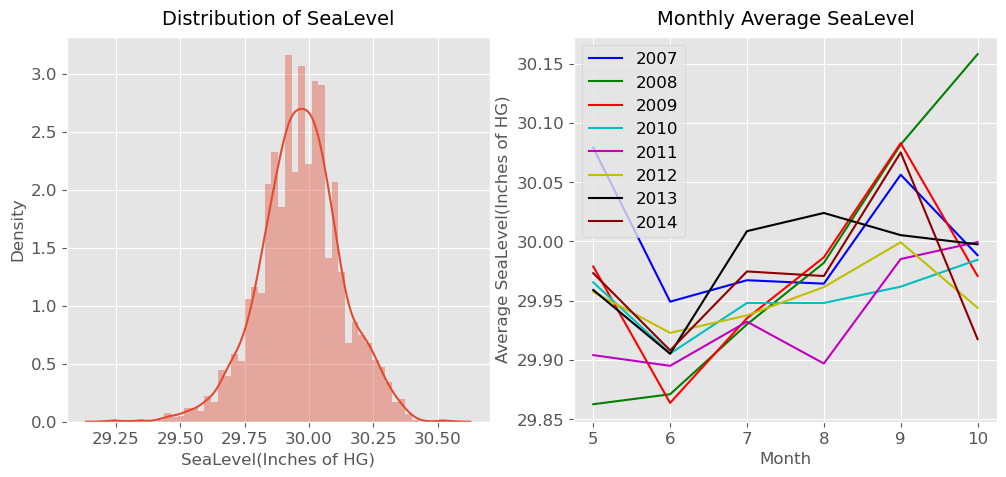

In [139]:
# Plot distribution of average SeaLevel and breakdown of each year
subplot_dist('sealevel',weather,'Distribution of SeaLevel','SeaLevel(Inches of HG)',\
            'Monthly Average SeaLevel','Month','Average SeaLevel(Inches of HG)')

- Distribution of SeaLevel follows a normal distribution.
- Monthly average SeaLevel does not show any trend throughout the years.
- SeaLevel values is similar to that of StnPressure, suggesting that the two may be collinear with one another.

`AvgSpeed`

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


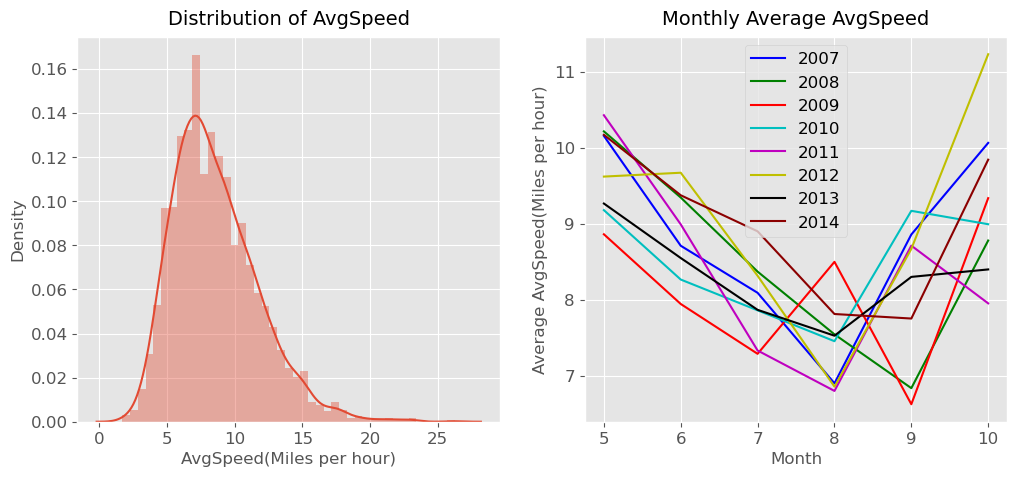

In [140]:
# Plot distribution of average AvgSpeed and breakdown of each year
subplot_dist('avgspeed',weather,'Distribution of AvgSpeed','AvgSpeed(Miles per hour)',\
            'Monthly Average AvgSpeed','Month','Average AvgSpeed(Miles per hour)')

- Distribution of AvgSpeed does not follow a normal distribution.
- Monthly AvgSpeed seems to fall in Aug or Sep each year.

`ResultSpeed`

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


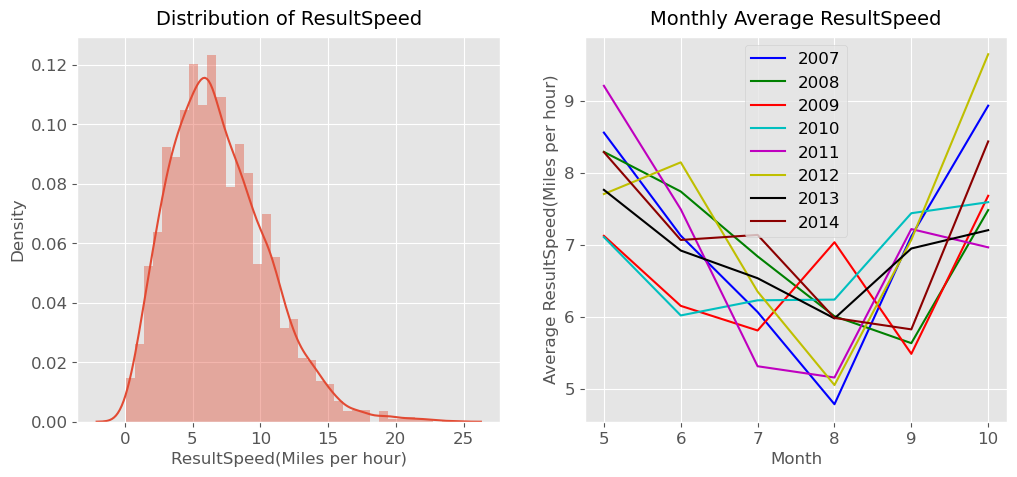

In [141]:
# Plot distribution of average ResultSpeed and breakdown of each year
subplot_dist('resultspeed',weather,'Distribution of ResultSpeed','ResultSpeed(Miles per hour)',\
            'Monthly Average ResultSpeed','Month','Average ResultSpeed(Miles per hour)')

- Distribution of ResultSpeed does not follow a normal distribution.
- Monthly ResultSpeed seems to fall in Aug or Sep each year, except for year 2010 where the lowest value was logged in the month of Jun.
- ResultSpeed values is quite similar to that of AvgSpeed, suggesting that the two may be collinear with one another.

`ResultDir`

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/2890326973.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_name], ax=ax[0])


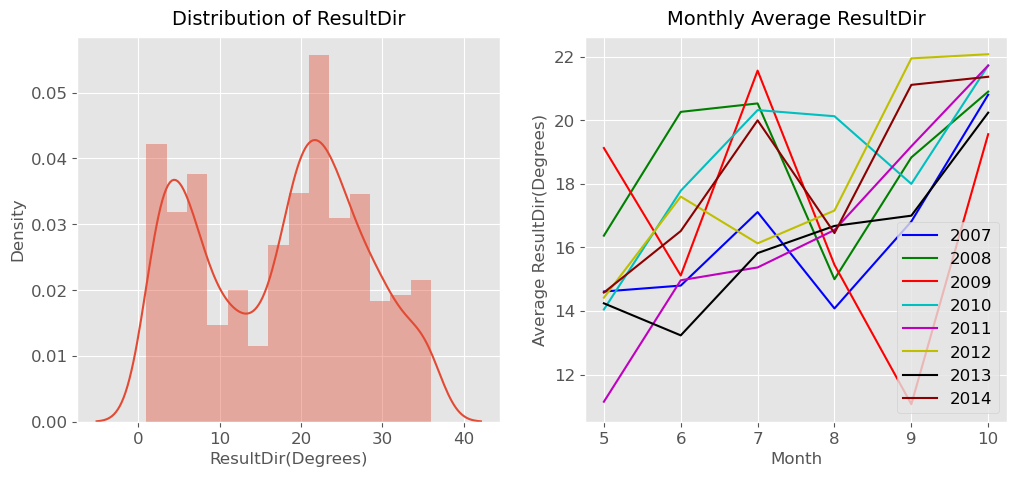

In [142]:
# Plot distribution of average ResultDir and breakdown of each year
subplot_dist('resultdir',weather,'Distribution of ResultDir','ResultDir(Degrees)',\
            'Monthly Average ResultDir','Month','Average ResultDir(Degrees)')

- Distribution of ResultDir does not follow a normal distribution.
- Monthly average ResultDir does not show any trend throughout the years.

`Tavg vs Mosquito count and Virus count on different dates`

In [143]:
# Merging 'nummosquitos' and 'wnvpresent' to the weather features with respect to date
df_mosquitos = train.groupby(['date'], as_index=False)[['nummosquitos']].sum()
df_virus = train.groupby(['date'], as_index=False)[['wnvpresent']].sum()
df_weather = weather.groupby(['date'], as_index=False)[['tavg','dewpoint', 'wetbulb','heat', 'cool',\
                                                        'preciptotal', 'stnpressure','sealevel',\
                                                        'resultspeed', 'resultdir', 'avgspeed']].mean()
df_wnv_mosquitos = pd.merge(df_mosquitos, df_virus, on = 'date')
weather_2 = pd.merge(df_wnv_mosquitos, df_weather)

In [144]:
weather_2.columns

Index(['date', 'nummosquitos', 'wnvpresent', 'tavg', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
       'resultdir', 'avgspeed'],
      dtype='object')

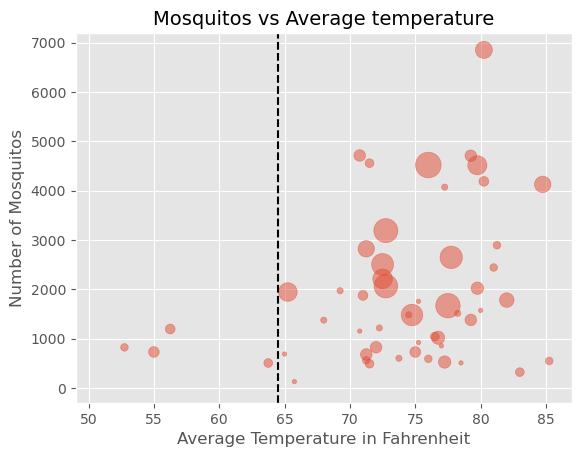

In [145]:
# Scatterplot for tavg
x = weather_2['tavg']
y = weather_2['nummosquitos']
z = weather_2['wnvpresent']
x_line = 64.5
plt.scatter(x, y, s=z*10, alpha=0.5)
plt.xlabel("Average Temperature in Fahrenheit", size=12)
plt.ylabel("Number of Mosquitos", size=12)
plt.title("Mosquitos vs Average temperature", size=14)
plt.axvline(x=x_line, ls='--', color='black')
plt.show()

Number of mosquitos and virus count have significantly high values for Tavg > 64.5.

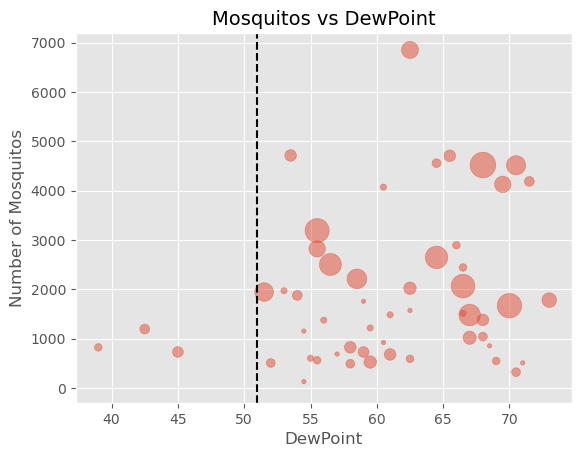

In [146]:
# Scatterplot for dewpoint
x = weather_2['dewpoint']
y = weather_2['nummosquitos']
z = weather_2['wnvpresent']
x_line = 51
plt.scatter(x, y, s=z*10, alpha=0.5)
plt.xlabel("DewPoint", size=12)
plt.ylabel("Number of Mosquitos", size=12)
plt.title("Mosquitos vs DewPoint", size=14)
plt.axvline(x=x_line, ls='--', color='black')
plt.show()

Number of mosquitos and virus count have significantly high values for DewPoint > 51.

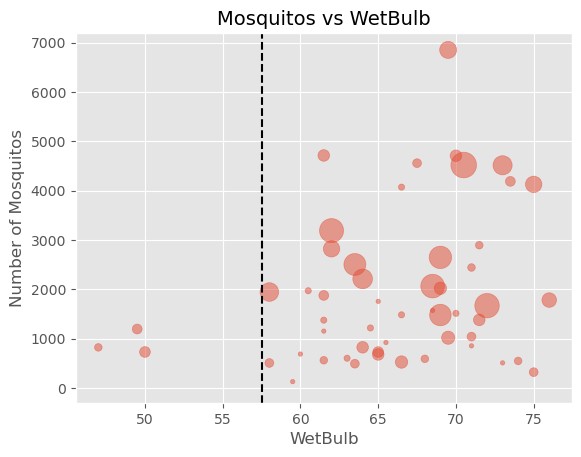

In [147]:
# Scatterplot for wetbulb
x = weather_2['wetbulb']
y = weather_2['nummosquitos']
z = weather_2['wnvpresent']
x_line = 57.5
plt.scatter(x, y, s=z*10, alpha=0.5)
plt.xlabel("WetBulb", size=12)
plt.ylabel("Number of Mosquitos", size=12)
plt.title("Mosquitos vs WetBulb", size=14)
plt.axvline(x=x_line, ls='--', color='black')
plt.show()

Number of mosquitos and virus count have significantly high values for WetBulb > 57.5.

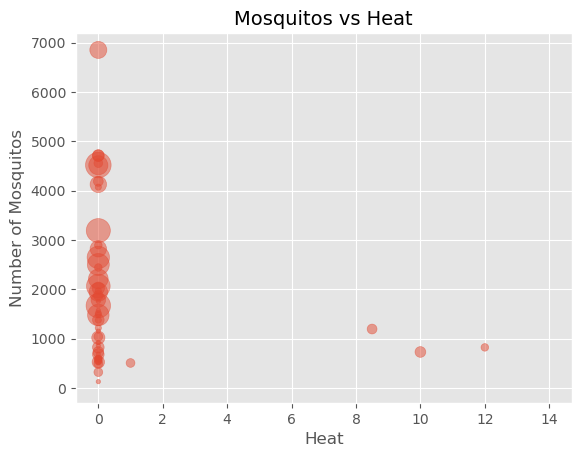

In [148]:
# Scatterplot for heat
x = weather_2['heat']
y = weather_2['nummosquitos']
z = weather_2['wnvpresent']
plt.scatter(x, y, s=z*10, alpha=0.5)
plt.xlabel("Heat", size=12)
plt.ylabel("Number of Mosquitos", size=12)
plt.title("Mosquitos vs Heat", size=14)
plt.show()

Mostly Heat has 0 value and it does not give any relation with virus count and number of mosquitos.

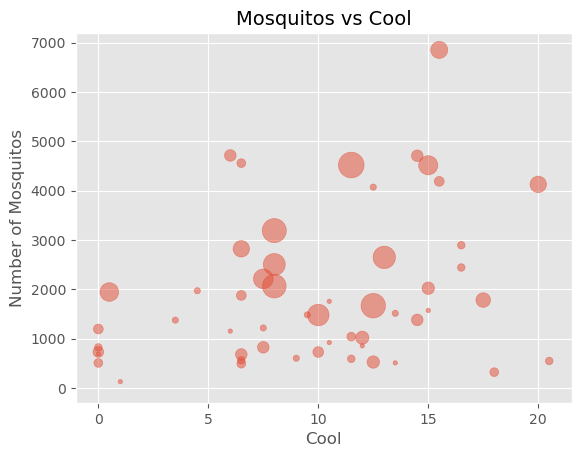

In [149]:
# Scatterplot for cool
x = weather_2['cool']
y = weather_2['nummosquitos']
z = weather_2['wnvpresent']
plt.scatter(x, y, s=z*10, alpha=0.5)
plt.xlabel("Cool", size=12)
plt.ylabel("Number of Mosquitos", size=12)
plt.title("Mosquitos vs Cool", size=14)
plt.show()

There are considerable number of mosquitos and virus count for entire spectrum of Cool.

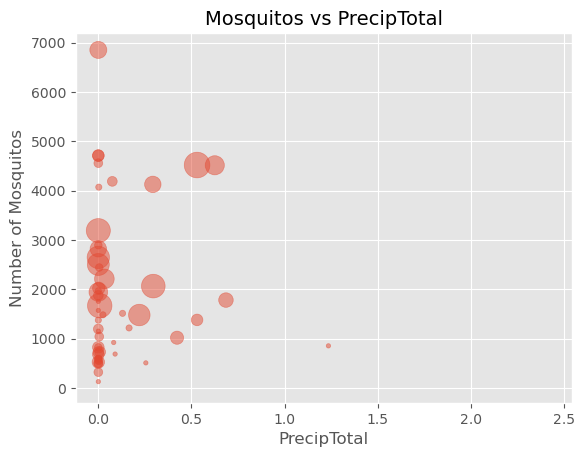

In [150]:
# Scatterplot for preciptotal
x = weather_2['preciptotal']
y = weather_2['nummosquitos']
z = weather_2['wnvpresent']
plt.scatter(x, y, s=z*10, alpha=0.5)
plt.xlabel("PrecipTotal", size=12)
plt.ylabel("Number of Mosquitos", size=12)
plt.title("Mosquitos vs PrecipTotal", size=14)
plt.show()

Preciptotal has mostly 0 value and it signifies dry weather condition. It might have some relation with virus count and number of mosquitos given that warm weather means a greater chance of infection.

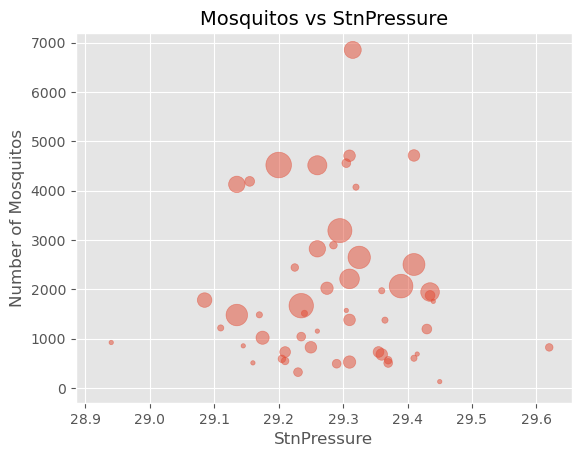

In [151]:
# Scatterplot for stnpressure
x = weather_2['stnpressure']
y = weather_2['nummosquitos']
z = weather_2['wnvpresent']
plt.scatter(x, y, s=z*10, alpha=0.5)
plt.xlabel("StnPressure", size=12)
plt.ylabel("Number of Mosquitos", size=12)
plt.title("Mosquitos vs StnPressure", size=14)
plt.show()

There are considerable number of mosquitos and virus count for entire spectrum of Stnpressure.

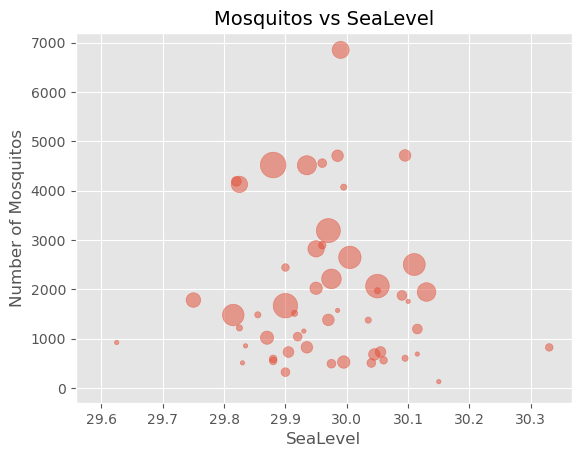

In [152]:
# Scatterplot for sealevel
x = weather_2['sealevel']
y = weather_2['nummosquitos']
z = weather_2['wnvpresent']
plt.scatter(x, y, s=z*10, alpha=0.5)
plt.xlabel("SeaLevel", size=12)
plt.ylabel("Number of Mosquitos", size=12)
plt.title("Mosquitos vs SeaLevel", size=14)
plt.show()

Sealevel tells the same story as Stnpressure.

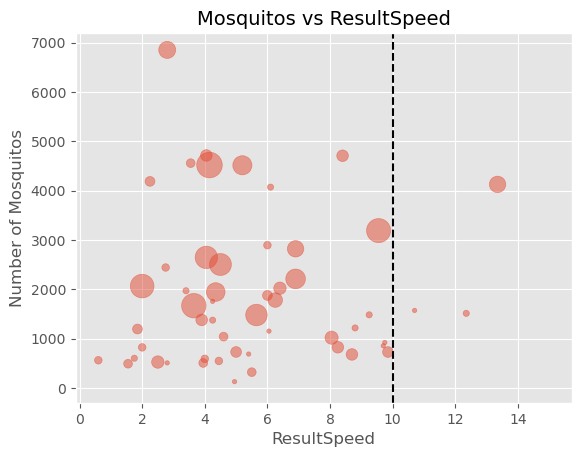

In [153]:
# Scatterplot for resultspeed
x = weather_2['resultspeed']
y = weather_2['nummosquitos']
z = weather_2['wnvpresent']
x_line = 10
plt.scatter(x, y, s=z*10, alpha=0.5)
plt.xlabel("ResultSpeed", size=12)
plt.ylabel("Number of Mosquitos", size=12)
plt.title("Mosquitos vs ResultSpeed", size=14)
plt.axvline(x=x_line, ls='--', color='black')
plt.show()

Number of mosquitos and virus count have significantly high values for ResultSpeed < 10.

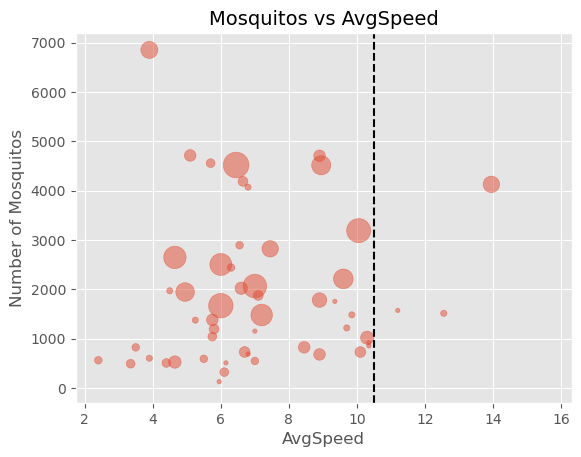

In [154]:
# Scatterplot for avgspeed
x = weather_2['avgspeed']
y = weather_2['nummosquitos']
z = weather_2['wnvpresent']
x_line = 10.5
plt.scatter(x, y, s=z*10, alpha=0.5)
plt.xlabel("AvgSpeed", size=12)
plt.ylabel("Number of Mosquitos", size=12)
plt.title("Mosquitos vs AvgSpeed", size=14)
plt.axvline(x=x_line, ls='--', color='black')
plt.show()

Number of mosquitos and virus count have significantly high values for AvgSpeed < 10.5.

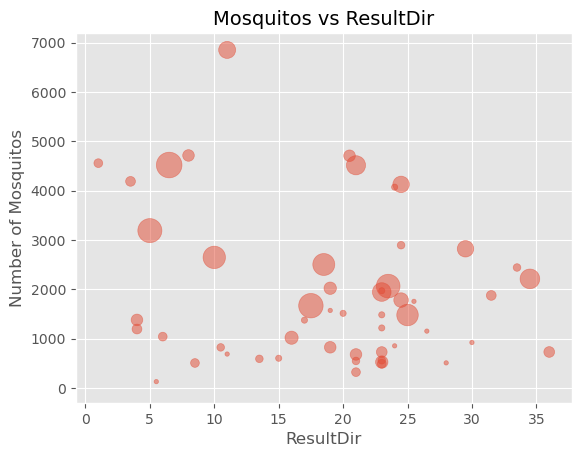

In [155]:
# Scatterplot for resultdir
x = weather_2['resultdir']
y = weather_2['nummosquitos']
z = weather_2['wnvpresent']
plt.scatter(x, y, s=z*10, alpha=0.5)
plt.xlabel("ResultDir", size=12)
plt.ylabel("Number of Mosquitos", size=12)
plt.title("Mosquitos vs ResultDir", size=14)
plt.show()

There are considerable number of mosquitos and virus count for entire spectrum of ResultDir.

[Back to top](#1)

## Feature Engineering

We will be allocating the locations of the traps to their nearest weather station for further analysis. 

The locations will be allocated by using geodesic distance, and a new feature 'station' will be included into our train_final dataset. 

#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT
#Station 2: CHICAGO MIDWAY INTL ARPT

In [156]:
# calculate distance between two points
station1 = (41.995, -87.933) #Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT
station2 = (41.786, -87.752) #Station 2: CHICAGO MIDWAY INTL ARPT

def get_station(lat, long):
    dist1 = geopy.distance.distance((lat, long), station1).km
    dist2 = geopy.distance.distance((lat, long), station2).km
    if dist1 < dist2:
        return 1
    else:
        return 2

In [157]:
train['station'] = np.nan

In [158]:
for i in train.index:
    train['station'][i] = get_station(train.loc[i,'latitude'], train.loc[i,'longitude'])

In [159]:
train.head()

date  species  trap   latitude  longitude  wnvpresent  year  month  \
0 2007-05-29      2.0  T048  41.867108 -87.654224           0  2007      5   
1 2007-05-29      1.0  T048  41.867108 -87.654224           0  2007      5   
2 2007-05-29      1.0  T091  41.862292 -87.648860           0  2007      5   
3 2007-05-29      1.0  T049  41.896282 -87.655232           0  2007      5   
4 2007-05-29      1.0  T153  41.907645 -87.760886           0  2007      5   

   day  nummosquitos  station  
0   29             1      2.0  
1   29             2      2.0  
2   29             1      2.0  
3   29             1      2.0  
4   29             1      2.0

In [160]:
#drop the year, month, day column
train.drop(columns = ['year', 'month', 'day'], inplace = True)
train.columns

Index(['date', 'species', 'trap', 'latitude', 'longitude', 'wnvpresent',
       'nummosquitos', 'station'],
      dtype='object')

In [161]:
#Combining all datasets into one
combined_df = pd.merge(train,weather,on=['date','station'],how='left')

In [162]:
combined_df.head()

date  species  trap   latitude  longitude  wnvpresent  nummosquitos  \
0 2007-05-29      2.0  T048  41.867108 -87.654224           0             1   
1 2007-05-29      1.0  T048  41.867108 -87.654224           0             2   
2 2007-05-29      1.0  T091  41.862292 -87.648860           0             1   
3 2007-05-29      1.0  T049  41.896282 -87.655232           0             1   
4 2007-05-29      1.0  T153  41.907645 -87.760886           0             1   

   station  tmax  tmin  tavg  dewpoint  wetbulb  heat  cool sunrise sunset  \
0      2.0    88    65  76.5        59     66.0   0.0  12.0    0420   1917   
1      2.0    88    65  76.5        59     66.0   0.0  12.0    0420   1917   
2      2.0    88    65  76.5        59     66.0   0.0  12.0    0420   1917   
3      2.0    88    65  76.5        59     66.0   0.0  12.0    0420   1917   
4      2.0    88    65  76.5        59     66.0   0.0  12.0    0420   1917   

   wetdry  preciptotal  stnpressure  sealevel  resultspeed  resultdir  \
0       1          0.0    29.440001     30.09          5.8         16   
1       1          0.0    29.440001     30.09          5.8         16   
2       1          0.0    29.440001     30.09          5.8         16   
3       1          0.0    29.440001     30.09          5.8         16   
4       1          0.0    29.440001     30.09          5.8         16   

   avgspeed  year  month  day  
0       7.4  2007      5   29  
1       7.4  2007      5   29  
2       7.4  2007      5   29  
3       7.4  2007      5   29  
4       7.4  2007      5   29

In [163]:
#OHE trap
combined_df = pd.get_dummies(columns = ['trap'], data = combined_df, drop_first = None)

In [164]:
#adding in extra column for trap 234 that does not exist in train dataset
combined_df['trap_T234'] = 0
combined_df.head()

date  species   latitude  longitude  wnvpresent  nummosquitos  \
0 2007-05-29      2.0  41.867108 -87.654224           0             1   
1 2007-05-29      1.0  41.867108 -87.654224           0             2   
2 2007-05-29      1.0  41.862292 -87.648860           0             1   
3 2007-05-29      1.0  41.896282 -87.655232           0             1   
4 2007-05-29      1.0  41.907645 -87.760886           0             1   

   station  tmax  tmin  tavg  dewpoint  wetbulb  heat  cool sunrise sunset  \
0      2.0    88    65  76.5        59     66.0   0.0  12.0    0420   1917   
1      2.0    88    65  76.5        59     66.0   0.0  12.0    0420   1917   
2      2.0    88    65  76.5        59     66.0   0.0  12.0    0420   1917   
3      2.0    88    65  76.5        59     66.0   0.0  12.0    0420   1917   
4      2.0    88    65  76.5        59     66.0   0.0  12.0    0420   1917   

   wetdry  preciptotal  stnpressure  sealevel  resultspeed  resultdir  \
0       1          0.0    29.440001     30.09          5.8         16   
1       1          0.0    29.440001     30.09          5.8         16   
2       1          0.0    29.440001     30.09          5.8         16   
3       1          0.0    29.440001     30.09          5.8         16   
4       1          0.0    29.440001     30.09          5.8         16   

   avgspeed  year  month  day  trap_T001  trap_T002  trap_T003  trap_T004  \
0       7.4  2007      5   29          0          0          0          0   
1       7.4  2007      5   29          0          0          0          0   
2       7.4  2007      5   29          0          0          0          0   
3       7.4  2007      5   29          0          0          0          0   
4       7.4  2007      5   29          0          0          0          0   

   trap_T005  trap_T006  trap_T007  trap_T008  trap_T009  trap_T011  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   trap_T012  trap_T013  trap_T014  trap_T015  trap_T016  trap_T017  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   trap_T018  trap_T019  trap_T025  trap_T027  trap_T028  trap_T030  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   trap_T031  trap_T033  trap_T034  trap_T035  trap_T036  trap_T037  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   trap_T039  trap_T040  trap_T043  trap_T044  trap_T045  trap_T046  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   trap_T047  trap_T048  trap_T049  trap_T050  trap_T051  trap_

In [165]:
test.head()

id       date  species  trap  latitude  longitude  year  month  day
0   1 2008-06-11      2.0  T002  41.95469 -87.800991  2008      6   11
1   2 2008-06-11      1.0  T002  41.95469 -87.800991  2008      6   11
2   3 2008-06-11      3.0  T002  41.95469 -87.800991  2008      6   11
3   4 2008-06-11      0.0  T002  41.95469 -87.800991  2008      6   11
4   5 2008-06-11      0.0  T002  41.95469 -87.800991  2008      6   11

In [166]:
#drop the year, month, day column
test.drop(columns = ['year', 'month', 'day'], inplace = True)
test.columns

Index(['id', 'date', 'species', 'trap', 'latitude', 'longitude'], dtype='object')

In [167]:
test['station'] = np.nan

In [168]:
for i in test.index:
    test['station'][i] = get_station(test.loc[i,'latitude'], test.loc[i,'longitude'])

In [169]:
#Combining all datasets into one
test_combined = pd.merge(test,weather,on=['date', 'station'],how='left')

In [170]:
#OHE trap
test_combined = pd.get_dummies(columns = ['trap'], data = test_combined, drop_first = None)

In [171]:
test_combined.head()

id       date  species  latitude  longitude  station  tmax  tmin  tavg  \
0   1 2008-06-11      2.0  41.95469 -87.800991      1.0    86    61  73.5   
1   2 2008-06-11      1.0  41.95469 -87.800991      1.0    86    61  73.5   
2   3 2008-06-11      3.0  41.95469 -87.800991      1.0    86    61  73.5   
3   4 2008-06-11      0.0  41.95469 -87.800991      1.0    86    61  73.5   
4   5 2008-06-11      0.0  41.95469 -87.800991      1.0    86    61  73.5   

   dewpoint  wetbulb  heat  cool sunrise sunset  wetdry  preciptotal  \
0        56     64.0   0.0   9.0    0416   1926       0          0.0   
1        56     64.0   0.0   9.0    0416   1926       0          0.0   
2        56     64.0   0.0   9.0    0416   1926       0          0.0   
3        56     64.0   0.0   9.0    0416   1926       0          0.0   
4        56     64.0   0.0   9.0    0416   1926       0          0.0   

   stnpressure  sealevel  resultspeed  resultdir  avgspeed  year  month  day  \
0    29.280001     29.99          8.9         18      10.0  2008      6   11   
1    29.280001     29.99          8.9         18      10.0  2008      6   11   
2    29.280001     29.99          8.9         18      10.0  2008      6   11   
3    29.280001     29.99          8.9         18      10.0  2008      6   11   
4    29.280001     29.99          8.9         18      10.0  2008      6   11   

   trap_T001  trap_T002  trap_T003  trap_T004  trap_T005  trap_T006  \
0          0          1          0          0          0          0   
1          0          1          0          0          0          0   
2          0          1          0          0          0          0   
3          0          1          0          0          0          0   
4          0          1          0          0          0          0   

   trap_T007  trap_T008  trap_T009  trap_T011  trap_T012  trap_T013  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   trap_T014  trap_T015  trap_T016  trap_T017  trap_T018  trap_T019  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   trap_T025  trap_T027  trap_T028  trap_T030  trap_T031  trap_T033  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   trap_T034  trap_T035  trap_T036  trap_T037  trap_T039  trap_T040  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   trap_T043  trap_T044  trap_T045  trap_T046  trap_T047  trap_T048  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   trap_T049  trap_T050  trap_T051  trap_T054  trap_T060  trap_T

In [172]:
print(test_combined.shape)
print(combined_df.shape)

(116293, 160)
(8610, 161)


<b>Exporting to csv</b>

In [173]:
# Save cleaned train dataset as a csv file
combined_df.to_csv('../data/train_final.csv', index=False)
test_combined.to_csv('../data/test_final.csv', index=False)

<b>Multicollinearity</b>

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_41816/3694650669.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


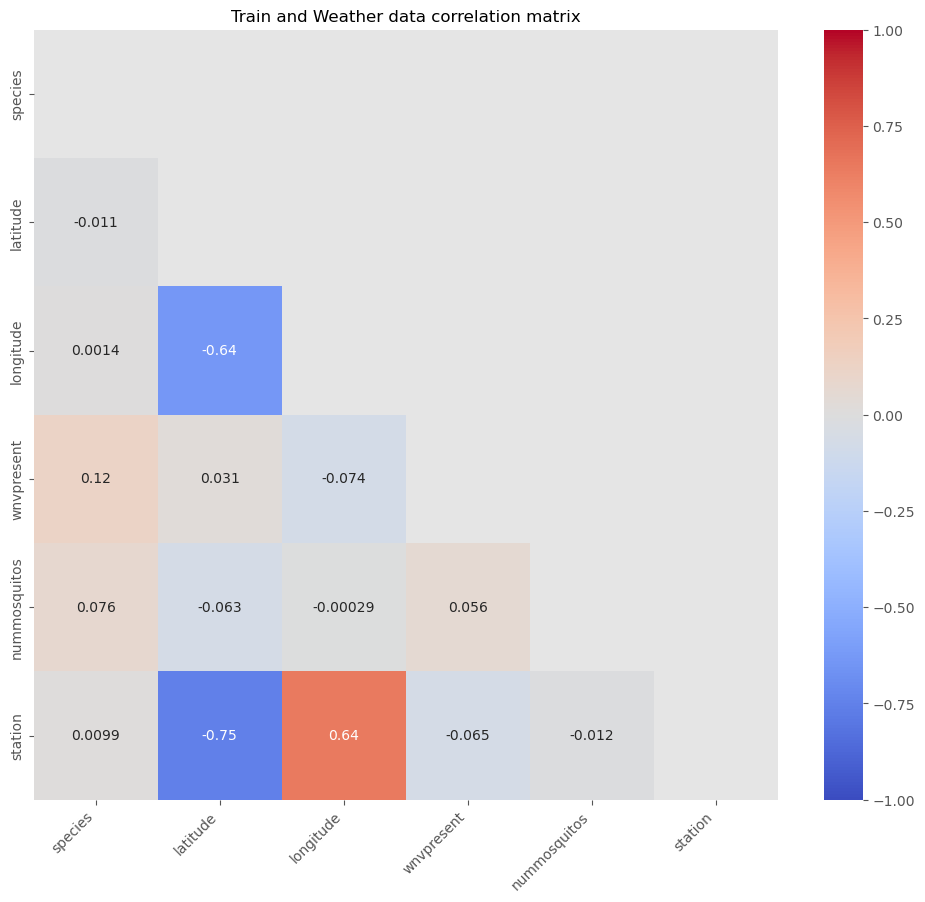

In [79]:
# Check for multicollinearity
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(12,10))
plt.title('Train and Weather data correlation matrix',fontsize = 12)
hmap = sns.heatmap(data = corr, vmin = -1, vmax=1, annot=True, mask = mask, cmap='coolwarm');
hmap.set_xticklabels(hmap.get_xticklabels(), rotation=45, horizontalalignment='right');

In [80]:
#dealing with multi-collinearity 
def VIF_calculator(data):
    vif_data = pd.DataFrame()
    num_idx = data.select_dtypes(include = ['int64', 'float64']).columns
    vif_data['feature'] = num_idx
    vif_data['VIF'] = [variance_inflation_factor(data[num_idx].values, i) for i in range(len(num_idx))]
    return vif_data[vif_data['VIF']>10]

In [81]:
VIF_calculator(combined_df)

/Users/lektiekleong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/lektiekleong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


feature           VIF
1    latitude  3.904692e+05
2   longitude  9.079310e+05
5     station  3.095280e+01
6        tmax           inf
7        tmin           inf
8        tavg           inf
9    dewpoint  5.423171e+02
13       year  2.026565e+05
14      month  6.141166e+01

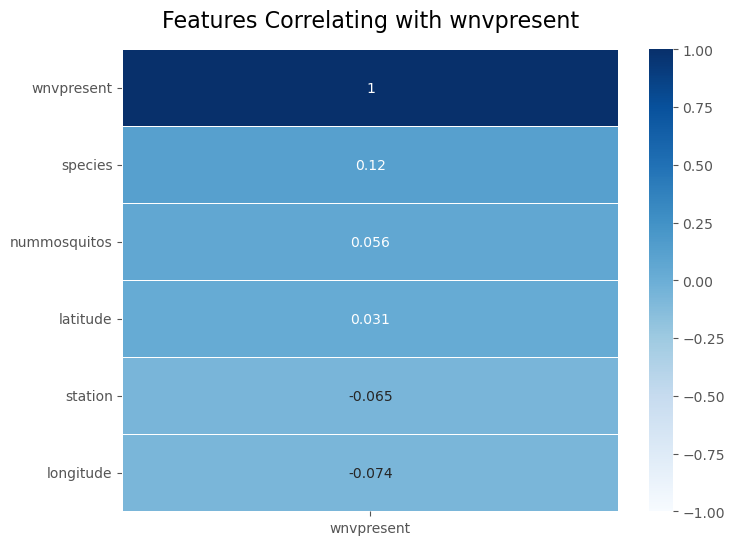

In [95]:
# Correlation heatmap with wnvpresent
plt.figure(figsize = (8,6))
heatmap = sns.heatmap(train.corr()[['wnvpresent']].sort_values(by='wnvpresent', ascending = False),
            annot=True, vmin=-1, vmax=1, linewidths=.5, cmap='Blues');
heatmap.set_title('Features Correlating with wnvpresent', fontdict={'fontsize':16}, pad=16);

[Back to top](#1)